In [1]:
import time
import os
import numpy as np

import torch
from torch import nn
from torch.nn import Linear, ReLU
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer

import pytorch_lightning as pl

import matplotlib.pyplot as plt

import wandb
from pytorch_lightning.loggers import WandbLogger

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,

    recall_score,
)

from cancernet.arch import InteractionNet, VisibleGraphInteractionNet, PNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps
from cancernet.arch.base_net import BaseNet
from cancernet.util import scatter_nd

/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


In [3]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("/mnt/home/cpedersen/ceph/Data/data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("/mnt/home/cpedersen/ceph/Data/data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [4]:
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


## Train

Set up hyperparameters and random seed.

In [5]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 200
batch_size = 10
lr = 0.001

Global seed set to 42


Prepare data.

In [6]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    num_workers=10
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    num_workers=10
)

In [7]:
model = PNet(
    layers=maps,
    num_genes=maps[0].shape[0], # 9054
    lr=lr
)

print("Number of params:",sum(p.numel() for p in model.parameters()))
logger = InMemoryLogger()


t0 = time.time()
# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=200,
    callbacks=[ProgressBar()],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

Number of params: 56888


/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.LightningLoggerBase` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.Logger` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name

Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Training took 681.6 seconds.


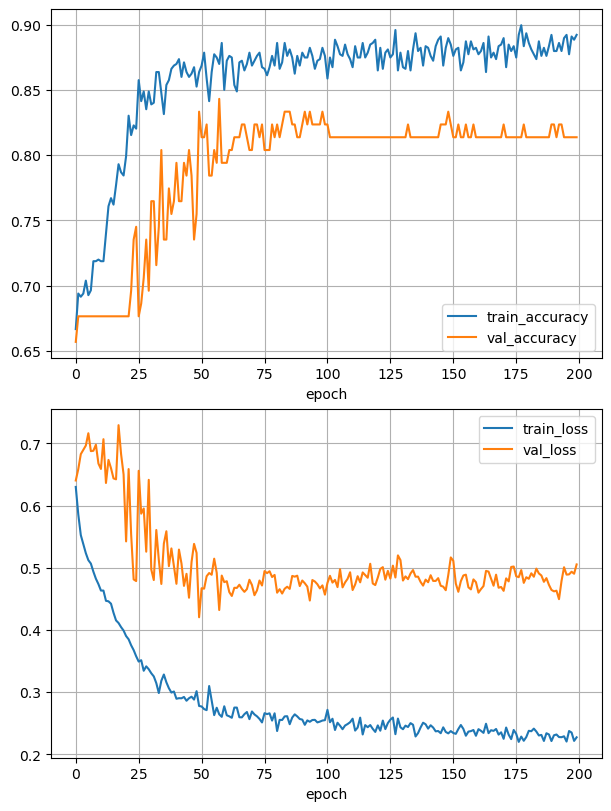

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Visualize training trajectory.

Calculate and show ROC and AUC.

accuracy 0.8137254901960784
auc 0.8779095300834431
aupr 0.8143201684754222
f1 0.6545454545454545
precision 0.8181818181818182
recall 0.5454545454545454


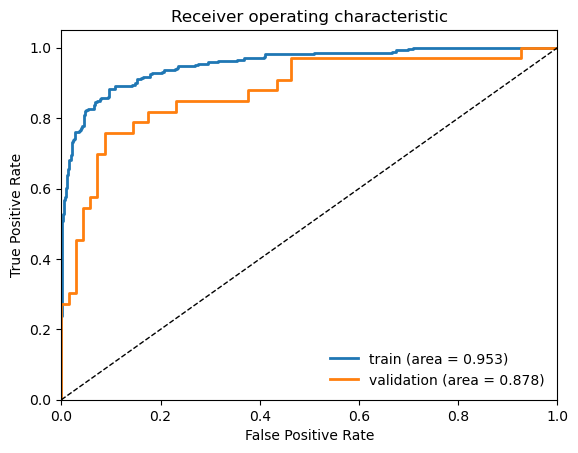

In [10]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader,exp=False)
fpr_valid, tpr_valid, valid_auc, ys, outs = get_roc(model, valid_loader,exp=False)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", valid_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

Check performance on test set.

In [11]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader,exp=False)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.78
auc 0.9181365897783809
aupr 0.8273776774003769
f1 0.5769230769230769
precision 0.7894736842105263
recall 0.45454545454545453
